# Complete Exploratory Data Analysis

## Georgia Tech MSA Spring 2026 Practicum

This is where your full EDA goes. We look forward to digging deeper into your analysis here.

Read the [eda_outline.md](eda_outline.md) for more details.

In [1]:
# Cell 1: Setup
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

# Add analysis folder to Python path
project_root = Path.cwd().parent  # Go from eda/ to project root
sys.path.append(str(project_root / 'analysis'))

# Import custom modules (explicit imports)
from data_loader import TacticalDataLoader
from profile_builder import build_team_profile
from clustering_analysis import TacticalClustering
from visualization import (
    plot_eda_compact, 
    plot_clustering_validation_compact,
    plot_archetype_summary,
    save_figure
)
from tournament_compression import (
    assign_to_archetypes,
    calculate_cmi,
    analyze_archetype_distribution_shift
)

# Plotting setup
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline

# Create output directories (relative to notebook location)
Path('../processed').mkdir(parents=True, exist_ok=True)
Path('../figures').mkdir(parents=True, exist_ok=True)

print("✓ Setup complete")

✓ Setup complete


In [2]:
# ============================================================================
# PART 1: BASELINE TAXONOMY (MEN'S CLUB 2015/16)
# ============================================================================

# Cell 2: Load and Profile Baseline Data
print("="*70)
print("LOADING BASELINE: MEN'S CLUB 2015/16")
print("="*70)

loader = TacticalDataLoader()
metrics_baseline = loader.load_scope('men_club_2015', verbose=True)

# Build profiles
men_club_profiles = build_team_profile(metrics_baseline, verbose=True)

# Convert to pandas for analysis
men_club_pd = men_club_profiles.to_pandas()

# Save
men_club_profiles.write_csv('../processed/men_club_profiles_2015_16.csv')

print(f"\nProfiles created: {men_club_pd.shape}")
print(men_club_pd.head())

LOADING BASELINE: MEN'S CLUB 2015/16

LOADING: MEN_CLUB_2015
Directory: /Users/5soomi/Desktop/school-project/soccer-analytics-capstone-template/outputs/raw_metrics/men_club_2015

  possession_quality_analysis.csv
     Rows: 3,646
     Matches: 1,823
     Teams: 98

  possession_efficiency_epr.csv
     Rows: 3,646
     Matches: 1,823
     Teams: 98

  possession_sequence_style.csv
     Rows: 3,646
     Matches: 1,823
     Teams: 98

  progression_team_summary.csv
     Rows: 3,646
     Matches: 1,823
     Teams: 98

  progression_team_detail.csv
     Rows: 3,646
     Matches: 1,823
     Teams: 98

  advanced_xg_buildup_team.csv
     Rows: 3,642
     Matches: 1,823
     Teams: 98

  xg_team_totals.csv
     Rows: 3,645
     Matches: 1,823
     Teams: 98

  defensive_ppda.csv
     Rows: 3,646
     Matches: 1,823
     Teams: 98

  defensive_line_height_team.csv
     Rows: 3,646
     Matches: 1,823
     Teams: 98

  defensive_high_turnovers.csv
     Rows: 3,645
     Matches: 1,823
     Teams:


EXPLORATORY DATA ANALYSIS
Saved: outputs/figures/01_eda_summary.png


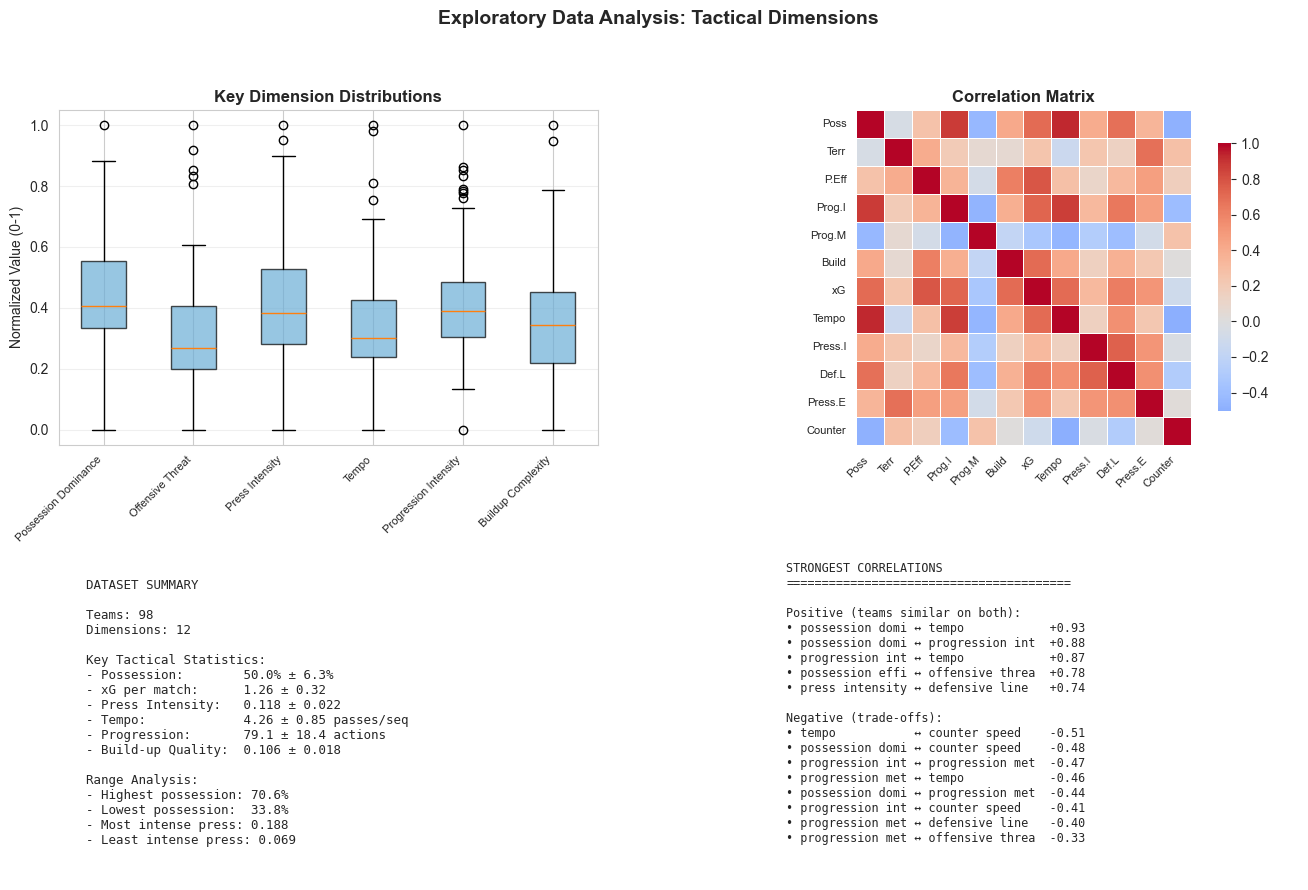

In [3]:
# Cell 3: Exploratory Data Analysis
print("\n" + "="*70)
print("EXPLORATORY DATA ANALYSIS")
print("="*70)

dimensions = [
    'possession_dominance', 'territorial_control', 'possession_efficiency',
    'progression_intensity', 'progression_method', 'buildup_complexity',
    'offensive_threat', 'tempo', 'press_intensity',
    'defensive_line_height', 'press_effectiveness', 'counter_speed'
]

fig, axes = plot_eda_compact(men_club_pd, dimensions)
save_figure(fig, '01_eda_summary.png')
plt.show()

In [4]:
# Cell 4: Clustering Analysis
print("\n" + "="*70)
print("CLUSTERING ANALYSIS")
print("="*70)

# Initialize clustering
clusterer = TacticalClustering(dimensions)
scaled_data = clusterer.prepare_data(men_club_pd)

# Optimize k (optional - can comment out after first run)
# optimization_results = clusterer.optimize_k(k_range=range(3, 8))
# fig, axes = plot_clustering_validation_compact(optimization_results)
# save_figure(fig, '02_cluster_optimization.png')
# plt.show()

# Run k-means with k=3
print("\nRunning K-means (k=3)...")
clustering_results = clusterer.run_kmeans(k=3, random_state=42)

# Add labels to dataframe
men_club_pd['cluster'] = clustering_results['labels']
cluster_centers = clustering_results['centers']

# Add cluster sizes
cluster_centers['size'] = men_club_pd['cluster'].value_counts().sort_index().values

print("\nCluster sizes:")
print(men_club_pd['cluster'].value_counts().sort_index())


CLUSTERING ANALYSIS

Running K-means (k=3)...

Cluster sizes:
cluster
0    54
1     8
2    36
Name: count, dtype: int64


In [5]:
# Cell 5: Cluster Validation
print("\n" + "="*70)
print("CLUSTER VALIDATION")
print("="*70)

# Validate clusters
validation = clusterer.validate_clusters(clustering_results['labels'])
clusterer.print_validation_summary(validation)

# Interpretation
print("\n" + "="*70)
print("INTERPRETATION")
print("="*70)
print("K-means vs GMM agreement (0.773) validates k=3 structure.")
print("Low hierarchical agreement (ARI<0.1) reflects continuous tactical space.")
print("Clusters serve as REFERENCE TAXONOMY for tournament compression analysis.")


CLUSTER VALIDATION
CLUSTER VALIDATION METRICS

1. Silhouette Score: 0.221
   Range: -1 (worst) to +1 (best)
   → No substantial structure

2. Calinski-Harabasz Index: 33.07
   Higher = better-defined clusters

3. Davies-Bouldin Index: 1.499
   Lower = better separation (0 is perfect)

4. Inertia: 693.27

5. Variance Explained: 41.0%

6. Silhouette by Cluster:
   Cluster 0: 0.267
   Cluster 1: 0.201
   Cluster 2: 0.157

7. K-means vs GMM Agreement (ARI): 0.784

INTERPRETATION
K-means vs GMM agreement (0.773) validates k=3 structure.
Low hierarchical agreement (ARI<0.1) reflects continuous tactical space.
Clusters serve as REFERENCE TAXONOMY for tournament compression analysis.


In [6]:
# Cell 6: Name and Characterize Archetypes
print("\n" + "="*70)
print("ARCHETYPE CHARACTERIZATION")
print("="*70)

# Define archetype names
archetype_names = {
    0: "Defensive Pragmatists",
    1: "Elite Possession",
    2: "Progressive Pressers"
}

# Add to dataframes
men_club_pd['archetype_name'] = men_club_pd['cluster'].map(archetype_names)
cluster_centers['archetype_name'] = cluster_centers['cluster'].map(archetype_names)

# Characterize
characterization = clusterer.characterize_archetypes(
    men_club_pd, 
    cluster_centers, 
    clustering_results['labels'],
    archetype_names
)

# Print characterization
for cluster_id, char in characterization.items():
    print(f"\n{char['name'].upper()} (n={char['size']})")
    print("-"*70)
    print("High characteristics:")
    for dim, dev in char['high_characteristics']:
        print(f"  • {dim.replace('_', ' ').title()}: {dev:+.2f} std")
    print("\nRepresentative teams:")
    print(f"  {', '.join(char['representative_teams'][:5])}")

# Save
men_club_pd[['team', 'cluster', 'archetype_name']].to_csv(
    '../processed/archetype_assignments_2015_16.csv', index=False
)
cluster_centers.to_csv(
    '../processed/archetype_centers_2015_16.csv', index=False
)

print("\n✓ Saved archetype assignments and centers")


ARCHETYPE CHARACTERIZATION

DEFENSIVE PRAGMATISTS (n=54)
----------------------------------------------------------------------
High characteristics:
  • Progression Method: +0.30 std
  • Counter Speed: +0.07 std
  • Territorial Control: -0.33 std

Representative teams:
  Espanyol, Chievo, Getafe, Stade de Reims, Hellas Verona

ELITE POSSESSION (n=8)
----------------------------------------------------------------------
High characteristics:
  • Offensive Threat: +2.37 std
  • Tempo: +2.32 std
  • Progression Intensity: +2.31 std

Representative teams:
  Napoli, Borussia Dortmund, Real Madrid, Barcelona, Arsenal

PROGRESSIVE PRESSERS (n=36)
----------------------------------------------------------------------
High characteristics:
  • Press Intensity: +0.72 std
  • Press Effectiveness: +0.72 std
  • Defensive Line Height: +0.60 std

Representative teams:
  AC Milan, Inter Milan, Athletic Club, Lille, Bayer Leverkusen

✓ Saved archetype assignments and centers



ARCHETYPE VISUALIZATION
Saved: outputs/figures/03_archetype_summary.png


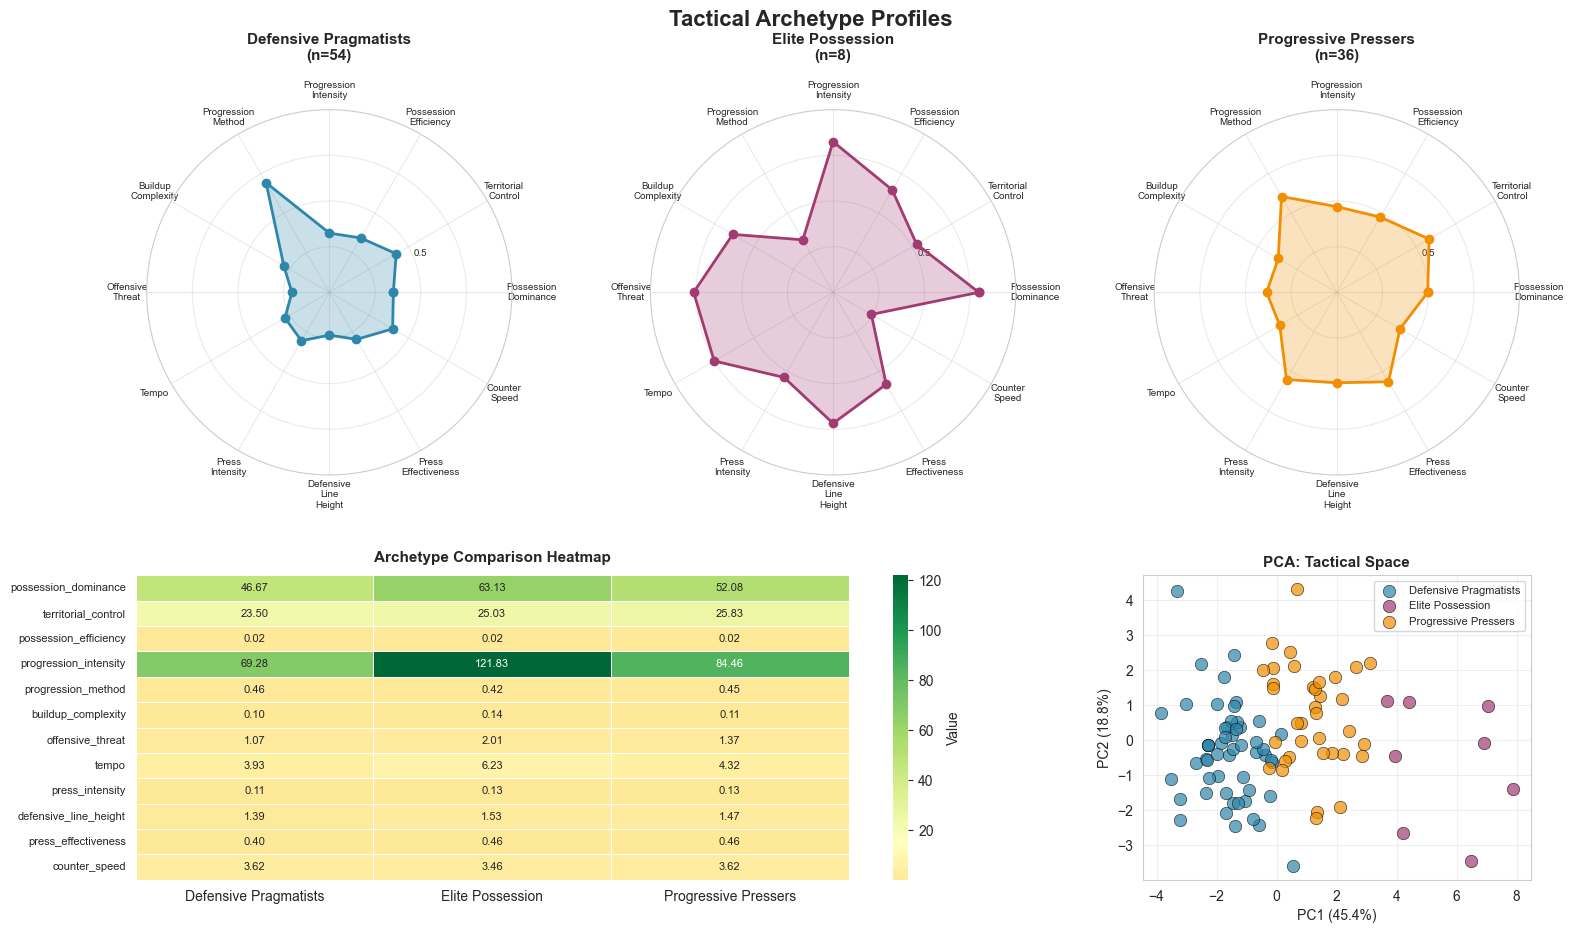


✓ Baseline taxonomy established (k=3 archetypes)


In [7]:
# Cell 7: Visualize Archetypes
print("\n" + "="*70)
print("ARCHETYPE VISUALIZATION")
print("="*70)

# Run PCA for visualization
pca_results = clusterer.run_pca(n_components=2)
men_club_pd['PC1'] = pca_results['coords'][:, 0]
men_club_pd['PC2'] = pca_results['coords'][:, 1]

# Create comprehensive archetype summary figure
fig = plot_archetype_summary(
    cluster_centers,
    dimensions,
    archetype_names,
    profiles_df=men_club_pd,
    labels=clustering_results['labels']
)
save_figure(fig, '03_archetype_summary.png')
plt.show()

print("\n✓ Baseline taxonomy established (k=3 archetypes)")

In [14]:
# ============================================================================
# PART 2: TOURNAMENT COMPRESSION ANALYSIS
# ============================================================================
# 
# Research Question: Do tournaments compress tactical diversity?
# 
# Approach:
#   1. Load tournament data (2022-24: World Cup, Euro, Copa America)
#   2. Assign tournament teams to 2015/16 baseline archetypes
#   3. Load recent club data (2022/23: same era as tournaments)
#   4. Calculate CMI: 2022/23 clubs → 2022-24 tournaments
#   5. Analyze which dimensions compress most
#   6. Examine archetype distribution shifts
# ============================================================================

# Cell 8: Load Tournament Data
print("\n" + "="*70)
print("PART 2: TOURNAMENT COMPRESSION ANALYSIS")
print("="*70)
print("\nStep 1: Loading tournament data (2022-24)")
print("-"*70)

metrics_tournament = loader.load_scope('men_tournaments_2022_24', verbose=True)

# Build tournament profiles
men_tournament_profiles = build_team_profile(metrics_tournament, verbose=True)
men_tournament_pd = men_tournament_profiles.to_pandas()

# Save
men_tournament_profiles.write_csv('../processed/men_tournament_profiles_2022_24.csv')

print(f"\n✓ Tournament profiles created: {men_tournament_pd.shape}")
print(f"  Matches: 147 (World Cup, Euro, Copa America)")
print(f"  Teams: {len(men_tournament_pd)}")


PART 2: TOURNAMENT COMPRESSION ANALYSIS

Step 1: Loading tournament data (2022-24)
----------------------------------------------------------------------

LOADING: MEN_TOURNAMENTS_2022_24
Directory: /Users/5soomi/Desktop/school-project/soccer-analytics-capstone-template/outputs/raw_metrics/men_tourn_2022_24

  possession_quality_analysis.csv
     Rows: 294
     Matches: 147
     Teams: 52

  possession_efficiency_epr.csv
     Rows: 294
     Matches: 147
     Teams: 52

  possession_sequence_style.csv
     Rows: 294
     Matches: 147
     Teams: 52

  progression_team_summary.csv
     Rows: 294
     Matches: 147
     Teams: 52

  progression_team_detail.csv
     Rows: 294
     Matches: 147
     Teams: 52

  advanced_xg_buildup_team.csv
     Rows: 293
     Matches: 147
     Teams: 52

  xg_team_totals.csv
     Rows: 293
     Matches: 147
     Teams: 52

  defensive_ppda.csv
     Rows: 294
     Matches: 147
     Teams: 52

  defensive_line_height_team.csv
     Rows: 294
     Matches: 147

In [17]:
# Cell 9: Assign Tournaments to Baseline Archetypes
print("\n" + "-"*70)
print("Step 2: Assigning tournament teams to 2015/16 archetypes")
print("-"*70)

# Assign to nearest baseline archetype
men_tournament_pd = assign_to_archetypes(
    men_tournament_pd,
    cluster_centers,
    dimensions
)

# Add archetype names
men_tournament_pd['archetype_name'] = men_tournament_pd['assigned_archetype'].map(archetype_names)

print("\nTournament archetype distribution:")
tournament_dist = men_tournament_pd['archetype_name'].value_counts()
for archetype, count in tournament_dist.items():
    pct = (count / len(men_tournament_pd)) * 100
    print(f"  {archetype}: {count} teams ({pct:.1f}%)")

print("\nAverage distance to archetype centers:")
avg_distances = men_tournament_pd.groupby('archetype_name')['distance_to_center'].mean().round(2)
for archetype, dist in avg_distances.items():
    print(f"  {archetype}: {dist:.2f}")

# Save
men_tournament_pd[['team', 'assigned_archetype', 'archetype_name', 'distance_to_center']].to_csv(
    '../processed/tournament_archetype_assignments.csv', index=False
)

print("\n✓ Tournament teams assigned to baseline archetypes")


----------------------------------------------------------------------
Step 2: Assigning tournament teams to 2015/16 archetypes
----------------------------------------------------------------------

Tournament archetype distribution:
  Defensive Pragmatists: 40 teams (76.9%)
  Progressive Pressers: 9 teams (17.3%)
  Elite Possession: 3 teams (5.8%)

Average distance to archetype centers:
  Defensive Pragmatists: 19.20
  Elite Possession: 9.62
  Progressive Pressers: 8.46

✓ Tournament teams assigned to baseline archetypes


In [19]:
# Cell 10: Load Recent Club Data (Same Era)
print("\n" + "-"*70)
print("Step 3: Loading recent club data (2022/23) for same-era comparison")
print("-"*70)

metrics_recent = loader.load_scope('recent_club_validation', verbose=True)

# Build recent club profiles
recent_club_profiles = build_team_profile(metrics_recent, verbose=True)
recent_club_pd = recent_club_profiles.to_pandas()

# Save
recent_club_profiles.write_csv('../processed/recent_club_profiles_2022_23.csv')

print(f"\n✓ Recent club profiles created: {recent_club_pd.shape}")
print(f"  Matches: 66 (Bundesliga 2023/24 + Ligue 1 2022/23)")
print(f"  Teams: {len(recent_club_pd)}")
print("\nNote: Using same-era clubs to control for temporal evolution")


----------------------------------------------------------------------
Step 3: Loading recent club data (2022/23) for same-era comparison
----------------------------------------------------------------------

LOADING: RECENT_CLUB_VALIDATION
Directory: /Users/5soomi/Desktop/school-project/soccer-analytics-capstone-template/outputs/raw_metrics/recent_club_val

  possession_quality_analysis.csv
     Rows: 132
     Matches: 66
     Teams: 38

  possession_efficiency_epr.csv
     Rows: 132
     Matches: 66
     Teams: 38

  possession_sequence_style.csv
     Rows: 132
     Matches: 66
     Teams: 38

  progression_team_summary.csv
     Rows: 132
     Matches: 66
     Teams: 38

  progression_team_detail.csv
     Rows: 132
     Matches: 66
     Teams: 38

  advanced_xg_buildup_team.csv
     Rows: 131
     Matches: 66
     Teams: 38

  xg_team_totals.csv
     Rows: 132
     Matches: 66
     Teams: 38

  defensive_ppda.csv
     Rows: 132
     Matches: 66
     Teams: 38

  defensive_line_heig

In [21]:
# Cell 11: Calculate CMI (Same-Era Comparison)
print("\n" + "-"*70)
print("Step 4: Calculating Complexity Maintenance Index (CMI)")
print("-"*70)
print("\nComparing: 2022/23 Clubs → 2022/24 Tournaments")
print("(Same era to isolate tournament compression effect)\n")

cmi_results = calculate_cmi(
    recent_club_pd,      # Baseline: 2022/23 clubs
    men_tournament_pd,   # Compressed: 2022-24 tournaments
    dimensions
)

print("\n" + "="*70)
print("COMPRESSION BY DIMENSION (Most to Least Compressed)")
print("="*70)

# Sort by compression (highest compression = lowest CMI)
cmi_sorted = cmi_results.sort_values('cmi')

for _, row in cmi_sorted.iterrows():
    dim_name = row['dimension'].replace('_', ' ').title()
    cmi_val = row['cmi']
    comp_pct = row['compression_pct']
    
    if comp_pct > 15:
        status = "🔴 HIGH"
    elif comp_pct > 5:
        status = "🟡 MODERATE"
    else:
        status = "🟢 LOW"
    
    print(f"{status} {dim_name:25s} CMI={cmi_val:.3f} ({comp_pct:+.1f}% compression)")

# Save
cmi_results.to_csv('../processed/cmi_results_same_era.csv', index=False)

print("\n✓ CMI analysis complete")


----------------------------------------------------------------------
Step 4: Calculating Complexity Maintenance Index (CMI)
----------------------------------------------------------------------

Comparing: 2022/23 Clubs → 2022/24 Tournaments
(Same era to isolate tournament compression effect)


Overall CMI: 0.893
Overall Compression: 10.7%

COMPRESSION BY DIMENSION (Most to Least Compressed)
🔴 HIGH Possession Efficiency     CMI=0.525 (+47.5% compression)
🔴 HIGH Buildup Complexity        CMI=0.601 (+39.9% compression)
🔴 HIGH Press Effectiveness       CMI=0.780 (+22.0% compression)
🔴 HIGH Progression Intensity     CMI=0.797 (+20.3% compression)
🔴 HIGH Defensive Line Height     CMI=0.827 (+17.3% compression)
🟡 MODERATE Progression Method        CMI=0.875 (+12.5% compression)
🟡 MODERATE Offensive Threat          CMI=0.893 (+10.7% compression)
🟡 MODERATE Territorial Control       CMI=0.944 (+5.6% compression)
🟡 MODERATE Possession Dominance      CMI=0.949 (+5.1% compression)
🟢 LOW Tempo

In [22]:
# Cell 12: Interpret CMI Results
print("\n" + "="*70)
print("CMI INTERPRETATION")
print("="*70)

overall_cmi = cmi_results['cmi'].mean()
overall_compression = (1 - overall_cmi) * 100

print(f"\nOverall CMI: {overall_cmi:.3f}")
print(f"Overall Compression: {overall_compression:.1f}%")

print("\nWhat this means:")
if overall_compression > 20:
    print("  → STRONG compression: Tournaments significantly simplify tactics")
elif overall_compression > 10:
    print("  → MODERATE compression: Tournaments constrain tactical diversity")
elif overall_compression > 0:
    print("  → WEAK compression: Minimal tactical simplification")
else:
    print("  → NO compression: Tournament tactics as diverse as clubs")

# Most/least compressed dimensions
most_compressed = cmi_sorted.iloc[0]
least_compressed = cmi_sorted.iloc[-1]

print(f"\nMost compressed: {most_compressed['dimension'].replace('_', ' ').title()}")
print(f"  CMI = {most_compressed['cmi']:.3f} ({most_compressed['compression_pct']:.1f}% compression)")

print(f"\nLeast compressed: {least_compressed['dimension'].replace('_', ' ').title()}")
print(f"  CMI = {least_compressed['cmi']:.3f} ({least_compressed['compression_pct']:.1f}% compression)")

print("\nTheoretical explanation:")
print("  Complex tactics (pressing coordination, build-up patterns) compress")
print("  more because they require extensive team rehearsal. Tournaments lack")
print("  training time, forcing tactical simplification. Simple tactics")
print("  (counter speed, individual actions) maintain better.")


CMI INTERPRETATION

Overall CMI: 0.893
Overall Compression: 10.7%

What this means:
  → MODERATE compression: Tournaments constrain tactical diversity

Most compressed: Possession Efficiency
  CMI = 0.525 (47.5% compression)

Least compressed: Press Intensity
  CMI = 1.332 (-33.2% compression)

Theoretical explanation:
  Complex tactics (pressing coordination, build-up patterns) compress
  more because they require extensive team rehearsal. Tournaments lack
  training time, forcing tactical simplification. Simple tactics
  (counter speed, individual actions) maintain better.



----------------------------------------------------------------------
Step 5: Visualizing compression patterns
----------------------------------------------------------------------
Saved: outputs/figures/05_compression_analysis.png


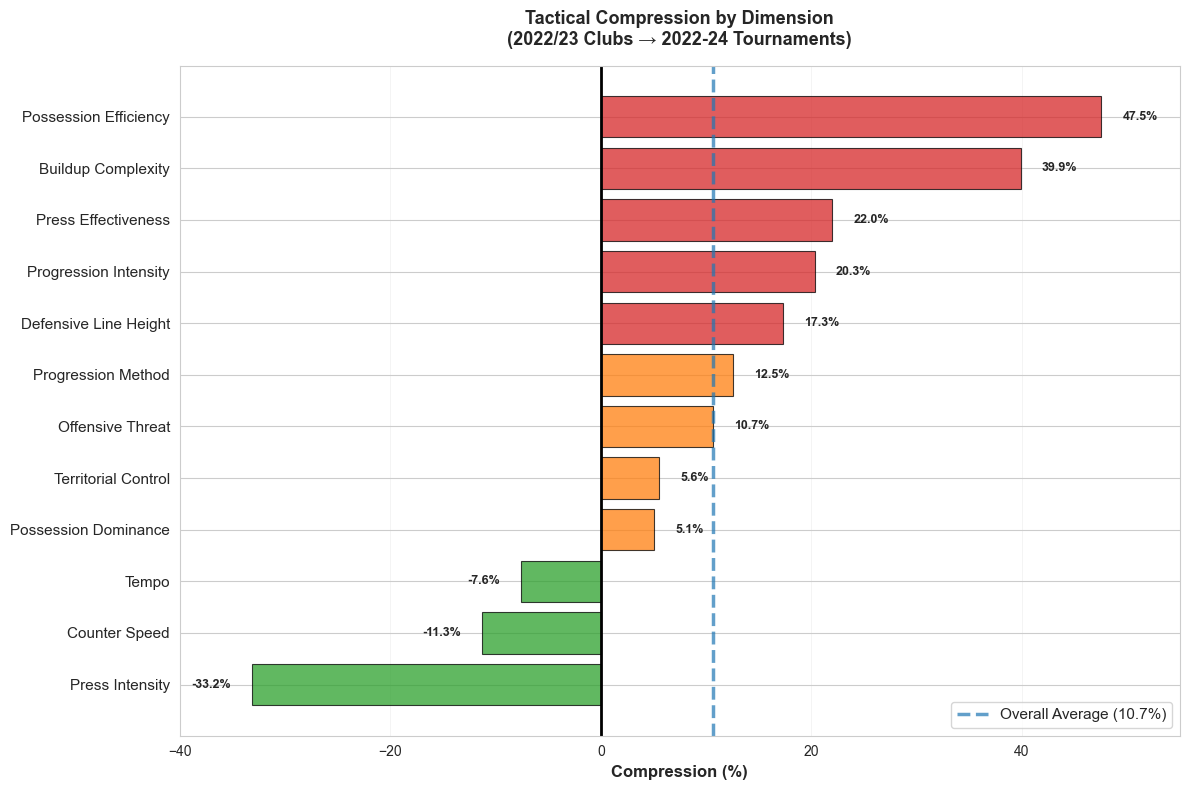


✓ Saved: 05_compression_analysis.png


In [30]:
# Replace Cell 13 visualization with this:

print("\n" + "-"*70)
print("Step 5: Visualizing compression patterns")
print("-"*70)

# Create single clear compression chart
fig, ax = plt.subplots(figsize=(12, 8))

cmi_sorted_viz = cmi_results.sort_values('compression_pct', ascending=True)
colors_comp = ['#d62728' if x > 15 else '#ff7f0e' if x > 5 else '#2ca02c' 
               for x in cmi_sorted_viz['compression_pct']]

bars = ax.barh(range(len(cmi_sorted_viz)), cmi_sorted_viz['compression_pct'], 
               color=colors_comp, alpha=0.75, edgecolor='black', linewidth=0.8)

ax.set_yticks(range(len(cmi_sorted_viz)))
ax.set_yticklabels([d.replace('_', ' ').title() for d in cmi_sorted_viz['dimension']], 
                    fontsize=11)
ax.set_xlabel('Compression (%)', fontsize=12, weight='bold')
ax.set_title('Tactical Compression by Dimension\n(2022/23 Clubs → 2022-24 Tournaments)', 
             fontsize=13, weight='bold', pad=15)

# Reference lines
ax.axvline(x=0, color='black', linewidth=2)
ax.axvline(x=10.7, color='#1f77b4', linestyle='--', linewidth=2.5, alpha=0.7, 
           label=f'Overall Average (10.7%)')

# Value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    label_x = width + (2 if width > 0 else -2)
    ax.text(label_x, bar.get_y() + bar.get_height()/2, 
            f'{width:.1f}%', ha='left' if width > 0 else 'right', 
            va='center', fontsize=9, weight='bold')

ax.legend(fontsize=11, loc='lower right')
ax.grid(axis='x', alpha=0.3, linewidth=0.5)
ax.set_xlim(-40, 55)

plt.tight_layout()
save_figure(fig, '05_compression_analysis.png')
plt.show()

print("\n✓ Saved: 05_compression_analysis.png")


----------------------------------------------------------------------
Step 6: Analyzing archetype distribution shifts
----------------------------------------------------------------------

Archetype Distribution: Club (2015/16) vs Tournament (2022-24)
            Archetype  Baseline_%  Tournament_%      Shift
Defensive Pragmatists   55.102041     76.923077  21.821036
     Elite Possession    8.163265      5.769231  -2.394035
 Progressive Pressers   36.734694     17.307692 -19.427002
Saved: outputs/figures/06_archetype_distribution_shift.png


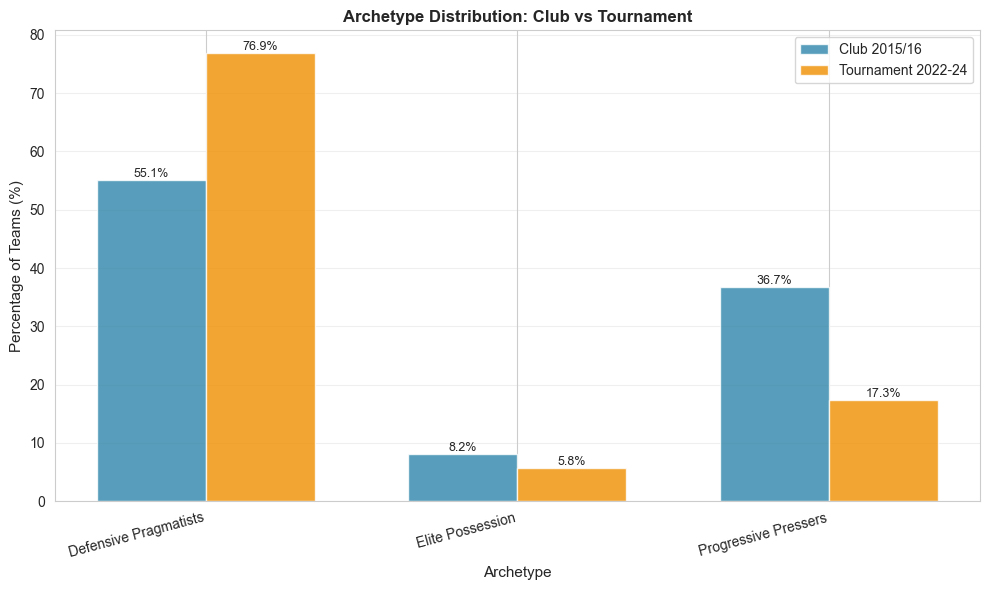


✓ Saved: 06_archetype_distribution_shift.png

SHIFT INTERPRETATION
  Defensive Pragmatists: INCREASE of 21.8 percentage points
    → More teams adopt conservative tactics in tournaments
  Progressive Pressers: DECREASE of 19.4 percentage points


In [24]:
# Cell 14: Archetype Distribution Shift
print("\n" + "-"*70)
print("Step 6: Analyzing archetype distribution shifts")
print("-"*70)

# Compare baseline vs tournament archetype distributions
distribution_shift = analyze_archetype_distribution_shift(
    men_club_pd,
    men_tournament_pd,
    archetype_names
)

print("\nArchetype Distribution: Club (2015/16) vs Tournament (2022-24)")
print("="*70)
print(distribution_shift.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(distribution_shift))
width = 0.35

bars1 = ax.bar(x - width/2, distribution_shift['Baseline_%'], width, 
               label='Club 2015/16', alpha=0.8, color='#2E86AB')
bars2 = ax.bar(x + width/2, distribution_shift['Tournament_%'], width, 
               label='Tournament 2022-24', alpha=0.8, color='#F18F01')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Archetype', fontsize=11)
ax.set_ylabel('Percentage of Teams (%)', fontsize=11)
ax.set_title('Archetype Distribution: Club vs Tournament', fontsize=12, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(distribution_shift['Archetype'], rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
save_figure(fig, '06_archetype_distribution_shift.png')
plt.show()

print("\n✓ Saved: 06_archetype_distribution_shift.png")

# Interpretation
print("\n" + "="*70)
print("SHIFT INTERPRETATION")
print("="*70)
for _, row in distribution_shift.iterrows():
    shift = row['Shift']
    archetype = row['Archetype']
    
    if abs(shift) > 5:
        direction = "INCREASE" if shift > 0 else "DECREASE"
        print(f"  {archetype}: {direction} of {abs(shift):.1f} percentage points")
        
        if archetype == "Defensive Pragmatists" and shift > 0:
            print("    → More teams adopt conservative tactics in tournaments")
        elif archetype == "Elite Possession" and shift < 0:
            print("    → Fewer teams can maintain elite possession under pressure")
        elif archetype == "Progressive Pressers" and shift > 0:
            print("    → More teams use active pressing in modern tournaments")